# Volatility prediction

### Imports

In [48]:
import yfinance as yf # Source of financial data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab 
import scipy.stats as stats
from scipy.stats import moment
import statsmodels.api as sm
#import colorama
from colorama import Fore
from colorama import Style

from arch import arch_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import norm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand


plt.rcParams["figure.figsize"] = (8, 5)

import warnings
warnings.filterwarnings('ignore')

### Getting the data

In [49]:
def get_sp500_ticker_list():
    """
    Returns a list with all SP500 tickers
    """
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    table = tables[0]
    ticker_list = table['Symbol']
    return ticker_list

In [50]:
def get_sample_ticker(ticker_list, s=5):
    sample = ticker_list.sample(s).to_list()
    return sample

In [51]:
def get_adj_close(ticker_list, start, end, interval):
    """
    Returns the adjusted close for a unique ticker as string or a list of tickers.
    Format of dates: 'yyyy-mm-dd'
    Possible intervals: '1d', '5d', '1mo' 
    or intraday measures but limited to max a week's worth: '1m', '2m', '5m', '15m', '30m'
    """
    full_df = yf.download(ticker_list, start=start, end=end, interval=interval)
    adj_close_df = np.log(full_df['Adj Close'])
    return adj_close_df

In [52]:
def get_adj_close_df(s=5, start='2020-01-01', end='2021-12-31', interval='1d', log = False):
    """
    Returns the returns df and adj close df for a unique ticker as string or a list of tickers.
    n = sample size
    Format of dates: 'yyyy-mm-dd'
    Possible intervals: '1d', '5d', '1mo' 
    or intraday measures but limited to max a week's worth: '1m', '2m', '5m', '15m', '30m'
    Returns a dataframe of a random sample of the sp500 adj closes over a certain period of time
    """
    sp500_tickers = get_sp500_ticker_list()
    sample_tickers = get_sample_ticker(sp500_tickers, s)
    full_df = yf.download(sample_tickers, start=start, end=end, interval=interval)
    if log == True:
        adj_close_df = np.log(full_df['Adj Close'])
    else:
        adj_close_df = full_df['Adj Close']
    return adj_close_df

In [53]:
def get_returns(adj_close_df):
    df_returns = (adj_close_df.pct_change())*100
    df_returns.dropna(axis=0,inplace=True)
    return df_returns

In [54]:
def get_volatility(returns_df):
    realized_vol = returns_df.rolling(5).std()
    realized_vol.dropna(inplace=True)
    return realized_vol

### Data analysis

In [55]:
adj_close_df = get_adj_close_df(s=5, start='2020-01-01', end='2021-12-31', interval='1d', log=True)

[*********************100%***********************]  5 of 5 completed


In [56]:
def plot_adj_close(adj_close_df, log=False):
    #plotting adjusted close price
    plt.plot(adj_close_df)
    plt.legend(adj_close_df.columns)
    if log == True:
        plt.title("Log Adjusted closing price of selected stocks")
    else:
        plt.title("Adjusted closing price of selected stocks")
    plt.show()

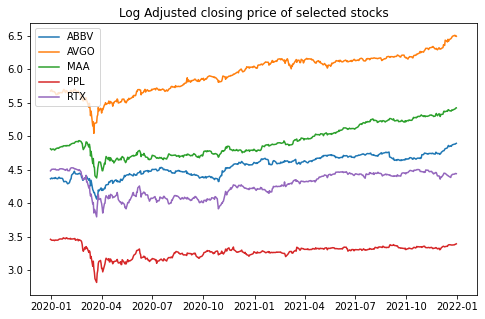

In [57]:
plot_adj_close(adj_close_df, log=True)

In [58]:
returns = get_returns(adj_close_df)

In [59]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [60]:
def plot_correlogram(returns, lags=None, title=None):
    
    lags = min(10, int(len(returns)/5)) if lags is None else lags

    #plots layout
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    #time series of return on top-left
    returns.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(returns, nlags=lags), len(returns))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(returns)[1]:>11.2f} \nHurst: {round(hurst(returns.values),2)}'

    #adding stats on top-left plot
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)

    #plotting qqplot on top-right
    probplot(returns, plot=axes[0][1])

    #calculating distributions moments
    mean, var, skew, kurtosis = moment(returns, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'

    #adding stats on top-right plot
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)

    #plot autocorrelation
    plot_acf(x=returns, lags=lags, zero=False, ax=axes[1][0])
    axes[1][0].set_xlabel('Lag')

    #plot autocorrelation function
    plot_pacf(returns, lags=lags, zero=False, ax=axes[1][1])
    axes[1][1].set_xlabel('Lag')

    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [61]:
def adf_test(returns):
    adfuller_results = adfuller(returns)
    
    print(Fore.BLUE + Style.BRIGHT + "ADF Test summary for "+ returns.name + Style.RESET_ALL)
    print(f'ADF Statistic:{adfuller_results[0]}')
    print(f'p-value: {adfuller_results[1]}')
    print('Critical Values:')
    for key, value in adfuller_results[4].items():
        print(f'{key}: {value:.4f}')

In [62]:
for i in range(len(returns.columns)):
    adf_test(returns.iloc[:,i])

ADF Test summary for ABBV
ADF Statistic:-7.298881834847752
p-value: 1.35502222208193e-10
Critical Values:
1%: -3.4437
5%: -2.8674
10%: -2.5699
ADF Test summary for AVGO
ADF Statistic:-8.778229434226242
p-value: 2.4160232646768654e-14
Critical Values:
1%: -3.4436
5%: -2.8674
10%: -2.5699
ADF Test summary for MAA
ADF Statistic:-12.885509866946435
p-value: 4.563117211961687e-24
Critical Values:
1%: -3.4435
5%: -2.8673
10%: -2.5699
ADF Test summary for PPL
ADF Statistic:-7.292522249332007
p-value: 1.4050922946684975e-10
Critical Values:
1%: -3.4436
5%: -2.8674
10%: -2.5699
ADF Test summary for RTX
ADF Statistic:-6.242649778650558
p-value: 4.6566164519502586e-08
Critical Values:
1%: -3.4437
5%: -2.8674
10%: -2.5699


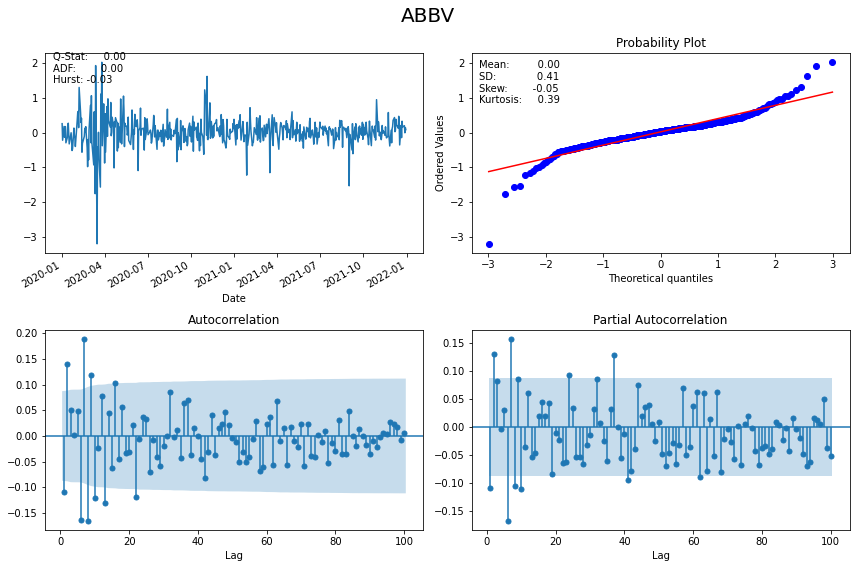

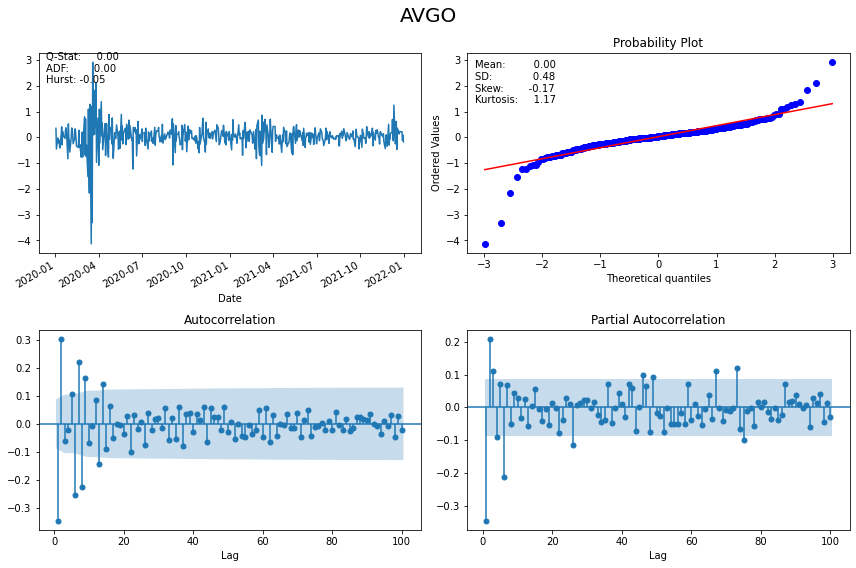

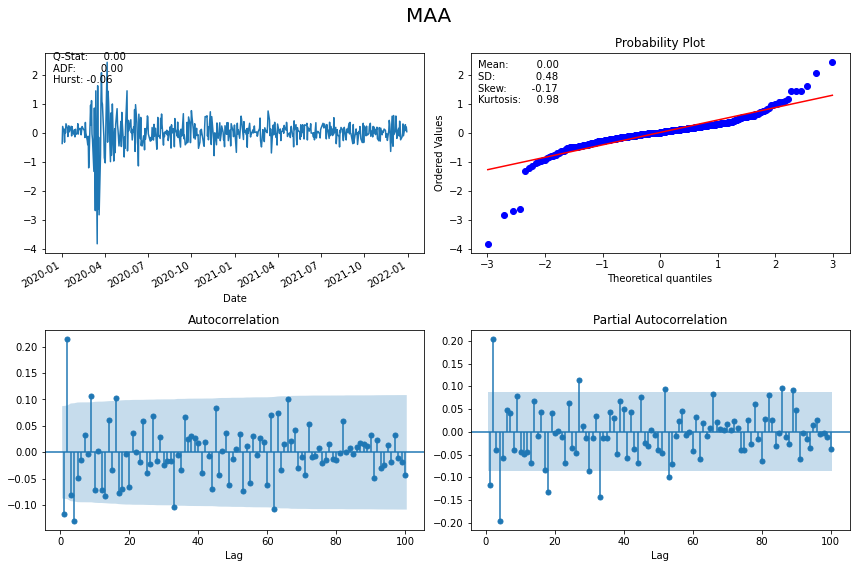

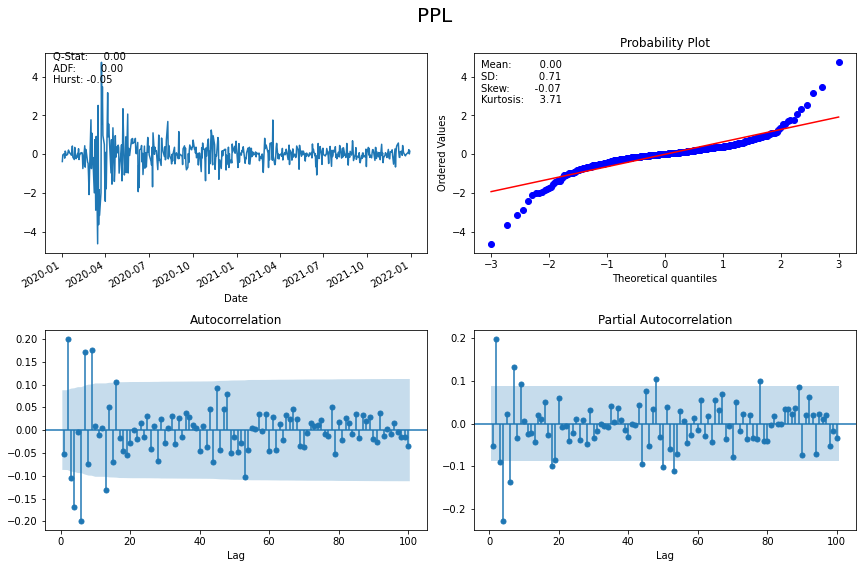

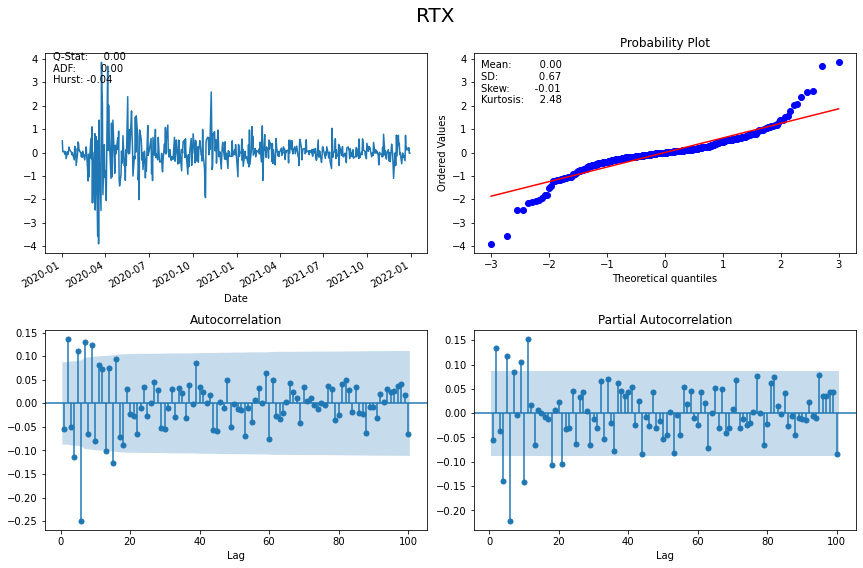

In [63]:
for i in range(len(returns.columns)):
    plot_correlogram(returns.iloc[:,i], lags=100, title=returns.iloc[:,i].name)

In [64]:
def plot_ret_dist(returns, dist="normal"):
    
    #plotting histograms to inspect distribution of the returns. We can clearly see fatter tails
    plt.figure(figsize=(7,4))
    
    if dist == "student":
        sns.distplot(returns, norm_hist=True, fit=stats.t, bins=30, color='r')
        plt.legend(('student-t', 'returns'))
    elif dist == "normal":
        sns.distplot(returns, norm_hist=True, fit=stats.norm, bins=30, color='r')
        plt.legend(('normal', 'returns'))
    plt.show()

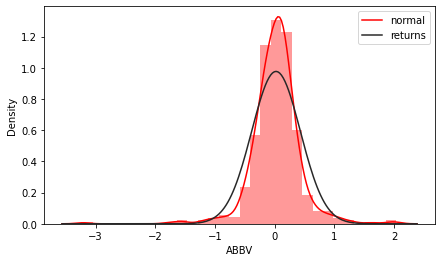

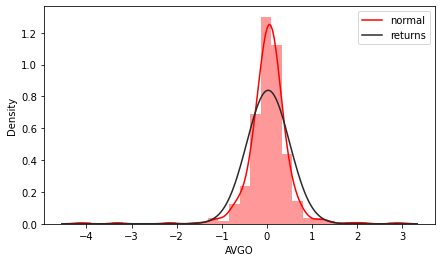

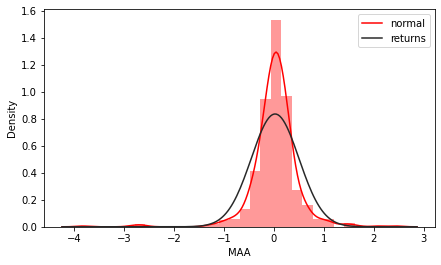

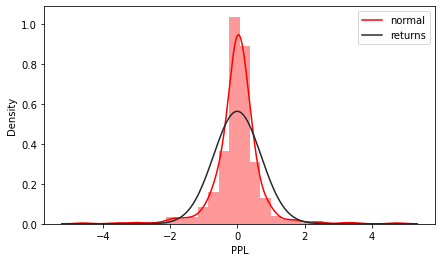

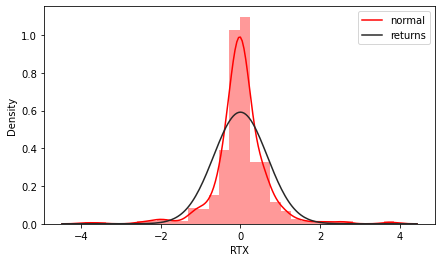

In [65]:
#evaluate return distribution with respect to a normal distribution
for i in range(len(returns.columns)):
    plot_ret_dist(returns.iloc[:,i], dist="normal")

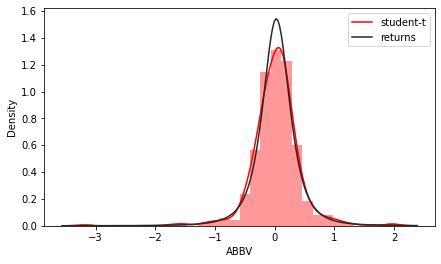

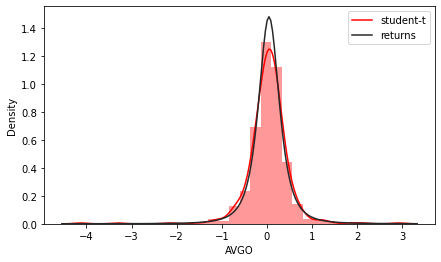

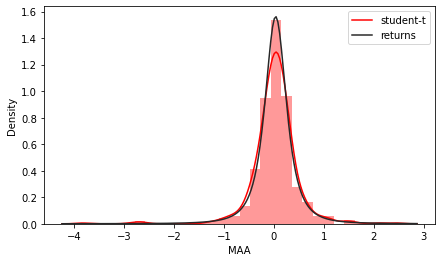

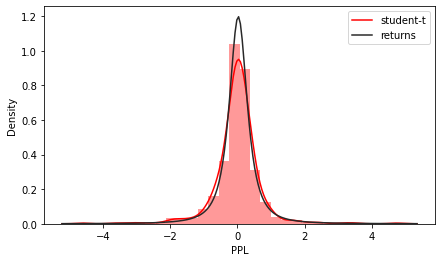

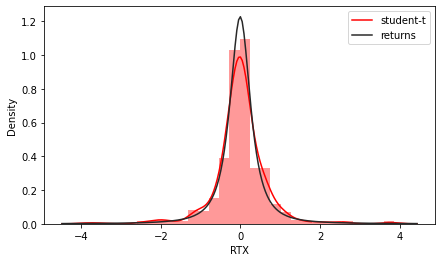

In [66]:
#evaluate return distribution with respect to a student distribution
for i in range(len(returns.columns)):
    plot_ret_dist(returns.iloc[:,i], dist="student")

In [67]:
vol = get_volatility(returns)

### Splitting the dataset by observations

In [68]:
def split_df(df, n):
    df_test = df.iloc[-n:]
    df_train = df.iloc[:-n]
    split_date = df.iloc[-n:].index
    return df_train, df_test, split_date

In [69]:
# Cross validation
# tscv = TimeSeriesSplit(n_splits=20, test_size=5)
# def get_train_test(df):
#     train_test_indices = {'train':{}, 'test':{}, 'split_dates': {}}
#     for i, (train_index, test_index) in enumerate(tscv.split(df)):
#         train_test_indices['train'][i] = train_index
#         train_test_indices['test'][i] = test_index
#         train_test_indices['split_dates'][i] = test_index[0]
#     return train_test_indices
# returns_splits = get_train_test(returns_df)
# volatility_splits = get_train_test(volatility_df)

### GARCH

In [70]:
def garch(returns, n):

    aic_garch = []

    for p in range(1, 5): 
        for q in range(1, 5):
            garch = arch_model(returns, mean='zero', vol='GARCH', p=p, q=q, dist="skewt")\
                .fit(disp='off') 
            aic_garch.append(garch.aic) 

            if garch.aic == np.min(aic_garch): 
                best_param = (p,q) 
    
    #fitting the best GARCH model
    garch = arch_model(returns, mean='zero', vol='GARCH', p=best_param[0], q=best_param[1], dist="skewt").fit(disp='off')

    #forecasts
    forecasts = garch.forecast(horizon=n, reindex=False)
    #forecasts = garch.forecast(horizon=50, start=split_date[0], reindex=True)
    return forecasts, forecasts.residual_variance.dropna().transpose()

In [71]:
def get_rmse(residuals, realized_vol):
    rmse = np.sqrt(mse(realized_vol/100, np.sqrt(residuals/100)))
    return rmse

### ARCH

In [72]:
def arch(returns, n):
    aic_arch = []

    for p in range(1, 5): # Iterating ARCH parameter p
        arch = arch_model(returns, mean='zero', vol='ARCH', p=p)\
             .fit(disp='off') # Running ARCH(p)
        aic_arch.append(arch.aic) # Storing aic for the ARCH(p)

        if arch.aic == np.min(aic_arch): 
             best_param = p # Finding the minimum AIC score
                
    # Fitting best arch
    arch = arch_model(returns, mean='zero', vol='ARCH', p=best_param)\
         .fit(disp='off')
    
    forecasts = arch.forecast(horizon=n, reindex=False)
    
    return forecasts, forecasts.residual_variance.dropna().transpose()

### GJR garch

In [73]:
def gjr_garch(returns, n):
    aic_gjr_garch = []

    for p in range(1, 5): 
        for q in range(1, 5):
            gjr_garch = arch_model(returns, mean='zero', vol='GARCH', p=p, o=1, q=q)\
                 .fit(disp='off') 
            aic_gjr_garch.append(gjr_garch.aic) 

            if gjr_garch.aic == np.min(aic_gjr_garch): 
                 best_param = p, q # Finding the minimum AIC score
    
    gjr_garch = arch_model(returns, mean='zero', vol='ARCH', p=best_param[0], o=1,
                       q=best_param[1]).fit(disp='off')
    
    forecasts = gjr_garch.forecast(horizon=n, reindex=True)
    
    return forecasts, forecasts.residual_variance.dropna().transpose()

### EGARCH

In [74]:
def egarch(returns, n):
    aic_egarch = []

    for p in range(1, 5):
        for q in range(1, 5):
            egarch = arch_model(returns, mean='zero', vol='EGARCH', p=p, q=q)\
                  .fit(disp='off')
            aic_egarch.append(egarch.aic)
            if egarch.aic == np.min(aic_egarch):
                best_param = (p, q)
    
    egarch = arch_model(returns, mean='zero', vol='EGARCH',
                        p=best_param[0], q=best_param[1], dist="skewt").fit(disp='off')
    
    forecasts = egarch.forecast(horizon=n, method='simulation', reindex=False)
    
    return forecasts, forecasts.residual_variance.dropna().transpose()

### Neural Nets

#### A primer on Artificial Neural Networks

A **artificial neural network** is an interconnection of neurons such that their output is connected, with a weight, to the inputs of other neurons. The most common neural architecture is the **Multi-Layer Perceptron** (MLP). This is the one we used in this work.  
A MLP is composed of one (passthrough) **input layer**, one or more intermediate layers, called **hidden layers**, and one final layer called the **output layer**. When an ANN contains a several hidden layers, it is called a **deep neural network** (DNN). 

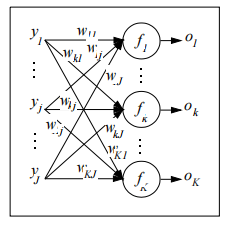

However, in our case, we will limit the theoretical presentation to a single hidden layer, because the deep neural case is just a generalisation to n-layers. 

In short an artificial neural network proceeds as follow:
- First, each neuron is fed some input. Each input is weighted by a weight $w_{kj} \quad \forall j \in \{1,...,J\}$ and $\forall k \in \{1,...,K\}$. 
- Then, the neuron acts like a processor and computes the sum of the inputs weighted.
$$ net_k = \sum_{j=1}^J w_{kj} y_j$$
- The output $o_k$ is then given by application of an activation function $ o_k = f_k(net_k)$

But, how are the optimal weights chosen?

The **error backpropagating** algorithm is currently the most popular learning algorithm. The backpropagation algorithm can find out how each connection weight and each term bias should be tweaked to reduce the error term. 

- For each training instance, the backpropagation algorithm first makes a prediction (forward pass) and measures the error
- It goes through each layer in reverse to measure the error contribution from each connection (backpropagation)
- Finally tweaks the connection weights to reduce the error using a Gradient steep descent.

In [75]:
def neural_net(Xs, n, NN_vol, para_grid_NN):
    X_predictions = {}
    for ticker, X in Xs.items():
        realized_vol = X[0]
        clf = RandomizedSearchCV(NN_vol, para_grid_NN)
        clf.fit(X.iloc[:-n].values,
            realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
        X_predictions[ticker] = clf.predict(X.iloc[-n:])
    return X_predictions

#### Neural nets & preprocessing

In [76]:
def get_svm_volatility(volatility_df):
    realized_vol = {}
    for ticker in volatility_df.columns:
        realized_vol[ticker] = pd.DataFrame(volatility_df[ticker]).reset_index(drop=True)
    return realized_vol

In [77]:
def get_svm_returns(returns_df):
    returns_svm = {}
    for ticker in returns_df.columns:
        returns_svm[ticker] = returns_df[ticker]**2
        returns_svm[ticker] = returns_svm[ticker].reset_index()
        del returns_svm[ticker]['Date']
    return returns_svm

In [78]:
def concat_ret_vol(returns_df, volatility_df):
    Xs = {}
    realized_vol = get_svm_volatility(volatility_df)#[:-4]
    returns_svm = get_svm_returns(returns_df)
    for ticker in volatility_df.keys():
        Xs[ticker] = pd.concat([realized_vol[ticker], returns_svm[ticker][:-4]], axis=1, ignore_index=True)
        
    return Xs

In [79]:
# def get_train_test_svm(Xs, n=50):
#     Xs_splitted = {}
#     for ticker, X in Xs.items():
#         Xs_splitted[ticker] = {}
#         Xs_splitted[ticker]['train'] = X.iloc[:-n]
#         Xs_splitted[ticker]['test'] = X.iloc[-n:]
#     return Xs_splitted

<!-- Xs_splitted = get_train_test_svm(Xs, n=50) -->

### RMSES

In [80]:
def get_rmses(s, n, start, end, interval):
    """
    s = how many companies
    n = sample size for testing
    """
    NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
    para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                'max_iter': [20000, 40000],
                'alpha': [0.00005, 0.0005 ]}
    rmses = {}
    
    # Get data
    adj_close_df = get_adj_close_df(s=s, start=start, end=end, interval=interval)
    
    # Get returns and volatility for arch type models
    returns_df = get_returns(adj_close_df)
    volatility_df = get_volatility(returns_df)
    
    # Splitting sets for arch type models
    df_train_vol, df_test_vol, split_date = split_df(volatility_df, n)
    df_train_ret, df_test_ret, split_date = split_df(returns_df, n)
    
    # Neural net preprocessing
    Xs = concat_ret_vol(returns_df, volatility_df)
    nn_predictions = neural_net(Xs, n, NN_vol, para_grid_NN)
    
    # Getting rmses
    for ticker in df_test_vol.columns:
        rmses[ticker] = {}
        
        #Neural net
        rmses[ticker]['nn'] = np.sqrt(mse(df_test_vol[ticker] / 100, nn_predictions[ticker] / 100))
        
        #Garch
        forecasts, residuals = garch(df_train_ret[ticker], n)
        rmses[ticker]['garch'] = get_rmse(residuals, df_test_vol[ticker])
        
        #Arch
        forecasts, residuals = garch(df_train_ret[ticker], n)
        rmses[ticker]['arch'] = get_rmse(residuals, df_test_vol[ticker])
        
        #GJR-garch
        forecasts, residuals = gjr_garch(df_train_ret[ticker], n)
        rmses[ticker]['gjr_garch'] = get_rmse(residuals, df_test_vol[ticker])
        
        #Egarch
        forecasts, residuals = egarch(df_train_ret[ticker], n)
        rmses[ticker]['egarch'] = get_rmse(residuals, df_test_vol[ticker])
        
    return rmses

In [81]:
# sample_daily_1y, adj_close_df = get_rmses(s=5, n=5, start='2017-01-17', end='2017-03-17', interval='1d')
# sample_daily_1y_df = pd.DataFrame(sample_daily_1y)
# sample_daily_1y_df.to_csv('sample_daily_1y.csv')
sample_daily_1y_df = pd.read_csv('sample_daily_1y.csv', index_col=0)
sample_daily_1y_df

,HUM,KEY,LNC,MOS,PYPL
nn,0.002382,0.001318,0.006900,0.000893,0.000773
garch,0.119689,0.116809,0.127331,0.128439,0.089246
arch,0.119689,0.116809,0.127331,0.128439,0.089246
gjr_garch,0.119688,0.126374,0.127390,0.182157,0.089250
egarch,0.200327,0.188522,0.218276,0.167622,0.348932


In [82]:
def plot_rmse(single_stock, e, title):
    if e == 0:
        models = ['Neural Net', 'Garch', 'Arch', 'Gjr-garch', 'Egarch']
        values = single_stock
    else:
        models = ['Neural Net', 'Garch', 'Arch', 'Gjr-garch']
        values = single_stock[:-1]
        
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.barh(models, values, color="salmon", alpha=0.9)
    plt.title(title)
    plt.show()

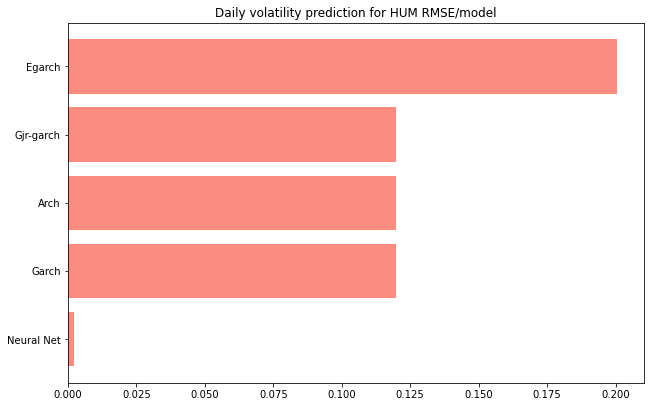

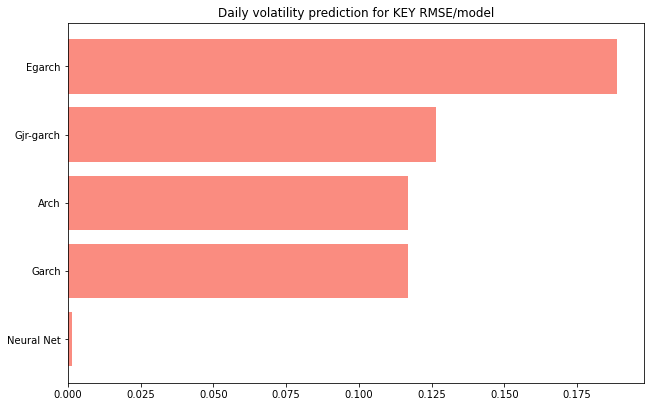

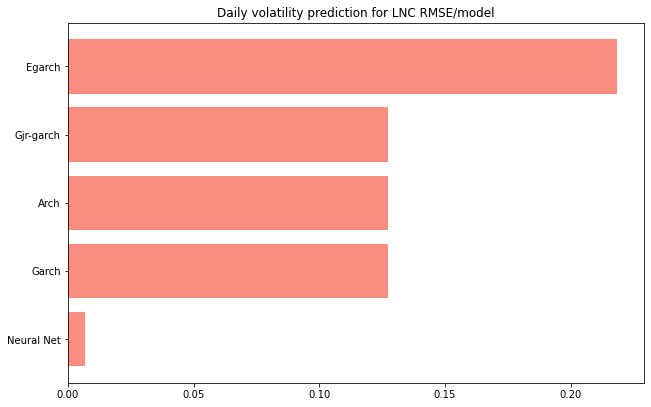

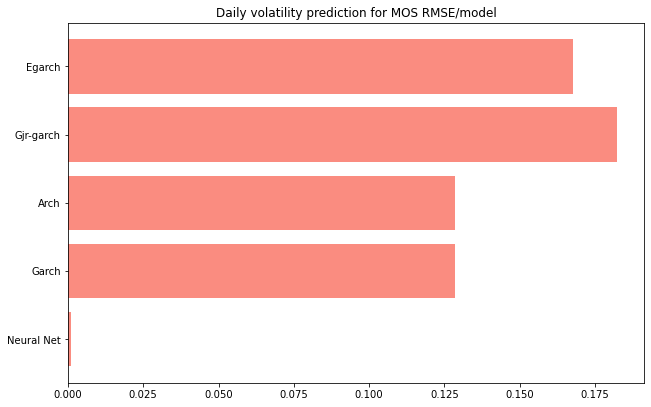

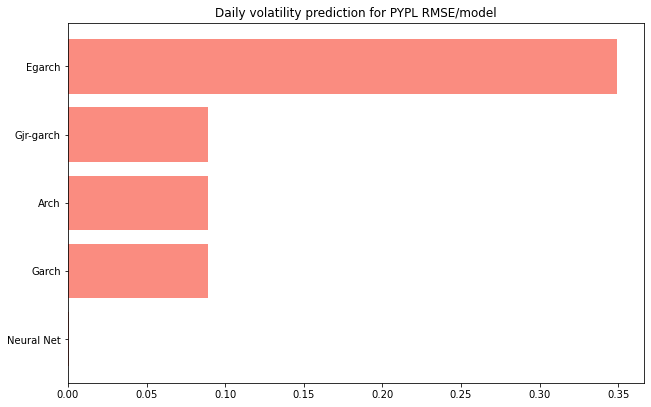

In [83]:
for ticker in sample_daily_1y_df.columns:
    plot_rmse(sample_daily_1y_df[ticker], 0, f'Daily volatility prediction for {ticker} RMSE/model')

In [84]:
sample_weekly_10y_df = pd.read_csv('sample_weekly_10y.csv', index_col=0)
sample_weekly_10y_df

,ADI,CPT,GL,RSG,V
nn,6.212129e-03,0.002598,0.002374,0.002115,0.005346
garch,3.577882e-01,0.443179,0.300571,0.347053,0.273248
arch,3.577882e-01,0.443179,0.300571,0.347053,0.273248
gjr_garch,2.682999e-01,0.229340,0.226870,0.183238,0.232233
egarch,2.032024e+08,32.045425,379.517528,249.148397,13.783146


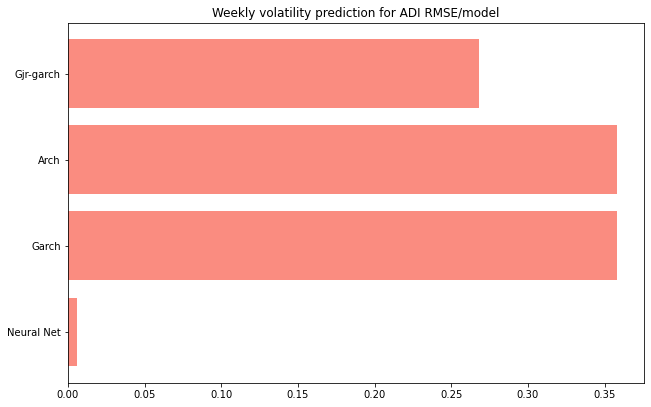

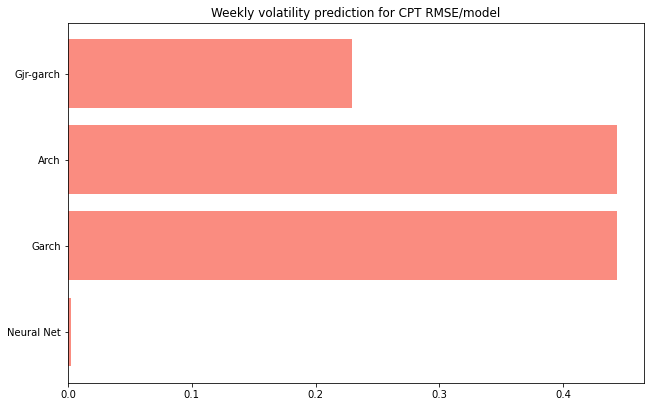

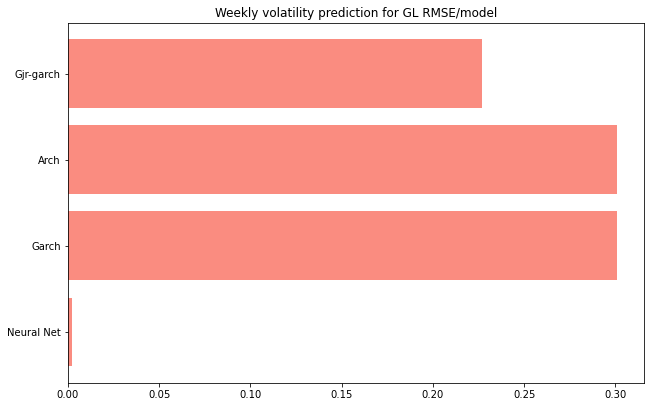

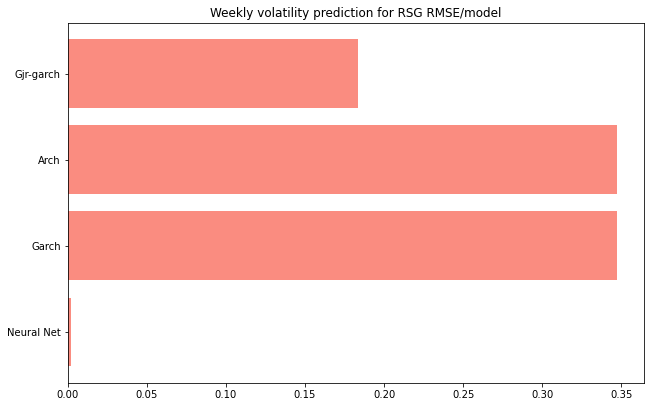

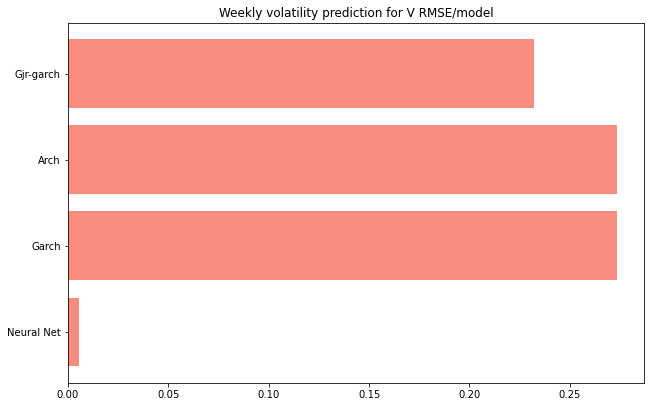

In [85]:
for ticker in sample_weekly_10y_df.columns:
    plot_rmse(sample_weekly_10y_df[ticker], 1, f'Weekly volatility prediction for {ticker} RMSE/model')

### Application

In [86]:
def var(s, n, start, end, interval, amount, level): 
    """
    s = how many companies
    n = sample size for testing
    """
    NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
    para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                'max_iter': [15000, 30000],
                'alpha': [0.00005, 0.0005 ]}
    rmses = {}
    
    # Get data
    adj_close_df = get_adj_close_df(s=s, start=start, end=end, interval=interval)
    
    # Get returns and volatility for arch type models
    returns_df = get_returns(adj_close_df)
    volatility_df = get_volatility(returns_df)
    
    # Splitting sets for arch type models
    df_train_vol, df_test_vol, split_date = split_df(volatility_df, n)
    df_train_ret, df_test_ret, split_date = split_df(returns_df, n)
    
    # Neural net preprocessing
    Xs = concat_ret_vol(returns_df, volatility_df)
    nn_predictions = neural_net(Xs, n, NN_vol, para_grid_NN)
    
    #Value at risk calculation
    var_dic = {}
    values = list(nn_predictions.values())
    i=0
    
    #a = np.random.random(s)
    #weights = a/(a.sum())
    
    for key in nn_predictions:
        var = norm.ppf(level)*(values[i][-1])/np.sqrt(100)*amount#*weights[i]
        var_dic[key] = var
        i=i+1
    
    plt.bar(range(len(var_dic)), list(var_dic.values()), align='center')
    plt.xticks(range(len(var_dic)), list(var_dic.keys()))
    plt.title("1% VaR of a 5-day horizon")
    plt.show()
    
    return var_dic

In [92]:
#value_at_risk = var(s=5, n=5, start='2017-01-17', end='2017-03-17', interval='1d', amount=1000000, level=0.99)
value_at_risk = {'CTRA': 415810.7820523615, 
                 'DHI': 288636.6762529738,
                 'HLT': 178467.604940284,
                 'SEE': 193522.4907944057,
                 'UDR': 304026.4456160802}

### Comparing NN performance on different distributions

In [93]:
# Get data
def nn_vs_moments(s, n, start, end, interval):
    
    NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
    para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                'max_iter': [10000, 20000],
                'alpha': [0.00005, 0.0005 ]}
    
    adj_close_df = get_adj_close_df(s=s, start=start, end=end, interval=interval)
    
    # Get returns and volatility
    returns_df = get_returns(adj_close_df)
    volatility_df = get_volatility(returns_df)
    df_train_vol, df_test_vol, split_date = split_df(volatility_df, n)
    
    # Neural net preprocessing
    Xs = concat_ret_vol(returns_df, volatility_df)
    nn_predictions = neural_net(Xs, n, NN_vol, para_grid_NN)
    
    # Moments and rmse
    moments_rmses = {}
    for ticker in volatility_df.columns:
        moments_rmses[ticker] = {}
        moments_rmses[ticker]['rmse'] = np.sqrt(mse(df_test_vol[ticker] / 100, nn_predictions[ticker] / 100))
        moments_rmses[ticker]['mean'] = moment(volatility_df[ticker], moment=1)
        moments_rmses[ticker]['variance'] = moment(volatility_df[ticker], moment=2)
        moments_rmses[ticker]['skewness'] = moment(volatility_df[ticker], moment=3)
        moments_rmses[ticker]['kurtosis'] = moment(volatility_df[ticker], moment=4)
        
    return moments_rmses

In [94]:
# moments_rmses = nn_vs_moments(s=60, n=5, start='2017-01-17', end='2017-04-17', interval='1d')
# moments_rmses_df = pd.DataFrame(moments_rmses)
# moments_rmses_df.to_csv('moments_rmses.csv')
moments_rmses_df = pd.read_csv('moments_rmses.csv', index_col=0)

In [95]:
moments_rmses_df = moments_rmses_df.T

In [138]:
# Remove outliers
trues = {}
for column in ['variance', 'skewness', 'kurtosis']:
    trues[column] = np.abs(stats.zscore(moments_rmses_df[column])) < 0.4
    
keepers = []
for ticker in trues['variance'].keys():
    keep = trues['variance'][ticker] * trues['skewness'][ticker] * trues['kurtosis'][ticker]
    if keep == True:
        keepers.append(ticker)
    else:
        continue

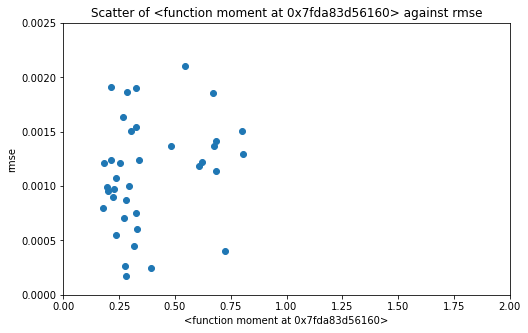

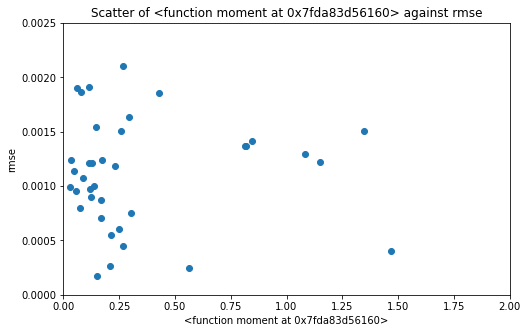

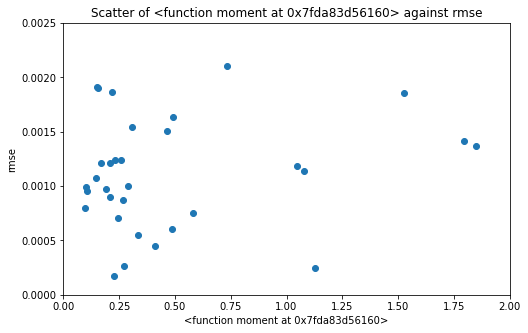

In [153]:
# Plot these tickers moments against the rmse
for column in ['variance', 'skewness', 'kurtosis']:
    plt.scatter(x=moments_rmses_df.loc[keepers][column], y=moments_rmses_df.loc[keepers]['rmse'])
    plt.axis((0,2,0,0.0025))
    plt.xlabel(moment)
    plt.ylabel('rmse')
    plt.title(f'Scatter of {colu} against rmse')
    plt.show()

(0.0, 1.0, 0.0, 1.0)

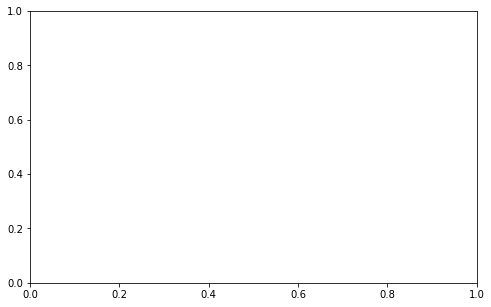

In [151]:
  
#plt.axis((x1,x2,25,250))
x1,x2,y1,y2